In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generate some data
mu_0 = -6
sigma_0 = 3
mu_1 = 3
sigma_1 = 2

n_clips = 2000
n_pos = 50

# generate data
scores = np.zeros(n_clips)
labels = np.zeros(n_clips)
scores[:n_pos] = np.random.normal(mu_1, sigma_1, n_pos)
labels[:n_pos] = 1
scores[n_pos:] = np.random.normal(mu_0, sigma_0, n_clips - n_pos)
labels[n_pos:] = 0

# make a labeling weighting. Try 1/rank
df = pd.DataFrame({'score': scores, 'label': labels})
df = df.sort_values("score", ascending=False)
df["weighting"] = 1/(1 + np.arange(len(df)))

# shuffle them just to remove any ordering
df = df.sample(frac=1)

# ensure labels are integers
df["label"] = df["label"].astype(int)

n_labeled = 20

# sample according to the weighting
labeled = df.sample(n_labeled, weights="weighting")
unlabeled = df.drop(labeled.index)

# normalize the labeled weights
labeled["weighting"] = labeled["weighting"] / labeled["weighting"].sum()

# make the data dictionary
data = {'N_labeled': len(labeled), 
        'N_unlabeled': len(unlabeled), 
        'scores_labeled': labeled['score'].values, 
        'scores_unlabeled': unlabeled['score'].values,
        'sampling_weight': labeled["weighting"].values,
        'labels': labeled["label"].values}

# make the data


Number of positives in labeled data: 13
proportion of positives in labeled data: 0.65
proportion of positives in all data: 0.025


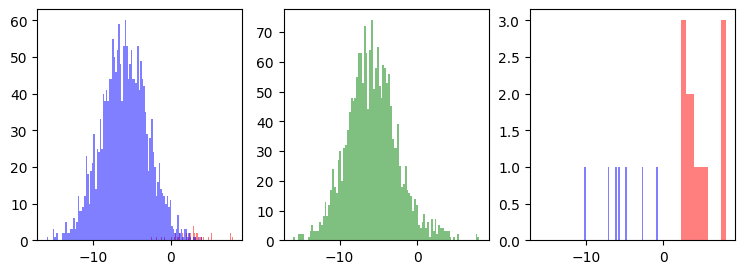

In [300]:
# plot the histogram of scores
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
pos = df[df['label'] == 1]
neg = df[df['label'] == 0]
ax[0].hist(pos['score'], bins=100, alpha=0.5, label='pos', color='red')
ax[0].hist(neg['score'], bins=100, alpha=0.5, label='neg', color='blue')
ax[1].hist(df['score'], bins=100, alpha=0.5, label='all', color='green')
ax[2].hist(labeled[labeled["label"] ==1]['score'], bins=10, alpha=0.5, label='labeled', color='red')
ax[2].hist(labeled[labeled["label"] ==0]['score'], bins=50, alpha=0.5, label='unlabeled', color='blue')
print(f"Number of positives in labeled data: {np.sum(labeled['label'])}")
print(f"proportion of positives in labeled data: {np.mean(labeled['label'])}")
print(f"proportion of positives in all data: {np.mean(df['label'])}")

In [301]:
#import cmdstanpy and use the stan model
import cmdstanpy
file = "weighted_sample_gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

In [302]:
# fit the model
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=250)

23:34:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:35:01 - cmdstanpy - INFO - CmdStan done processing.
23:35:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Consider re-running with show_console=True if the above output is unclear!


In [303]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7318.50000,0.082032,1.619330,-7321.73000,-7318.14000,-7316.55000,389.67800,122.42500,1.00436
mu[1],-6.37144,0.001784,0.057743,-6.46571,-6.37084,-6.27933,1047.48000,329.08600,1.00109
mu[2],2.31533,0.012453,0.299406,1.76133,2.34706,2.75992,578.02900,181.59900,1.00052
sigma[1],2.79492,0.001351,0.043846,2.72215,2.79460,2.86931,1053.52000,330.98500,1.00080
sigma[2],1.45305,0.008760,0.204667,1.15167,1.43316,1.81604,545.83400,171.48400,1.00287
theta,0.02831,0.000170,0.004120,0.02205,0.02804,0.03530,594.00798,186.61891,1.00053
n_pos_pred,67.44900,0.386990,9.033770,55.00000,66.00000,84.00000,544.93002,171.20013,1.00123


In [308]:
# now compare it to regular gmm model
file = "gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=500)
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()

23:37:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:37:44 - cmdstanpy - INFO - CmdStan done processing.
23:37:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
Consider re-running with show_console=True if the above output is unclear!


In [309]:
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-5189.660000,0.063342,1.627360,-5192.760000,-5189.360000,-5187.570000,660.066000,44.201800,1.003330
mu[1],-6.168700,0.005069,0.116877,-6.371490,-6.161520,-5.989770,531.712000,35.606500,1.003150
mu[2],-0.477173,0.098947,1.923350,-3.855750,-0.287174,2.356880,377.843000,25.302600,0.998481
sigma[1],2.891850,0.003274,0.078291,2.758820,2.895180,3.012870,571.963000,38.301900,1.003180
sigma[2],3.299390,0.035309,0.740586,2.127310,3.298830,4.492110,439.919000,29.459500,0.999097
theta,0.083776,0.002670,0.053212,0.029077,0.067311,0.195276,397.239903,26.601480,1.000749
n_pos_pred,166.826000,5.334064,106.255969,59.000000,133.000000,386.000000,396.816972,26.573158,1.000622


In [313]:
# try with the GP model
#import cmdstanpy and use the stan model
file = "GP.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

23:38:50 - cmdstanpy - INFO - compiling stan file /Users/LOF19/Dev/stan_models/GP.stan to exe file /Users/LOF19/Dev/stan_models/GP
23:39:10 - cmdstanpy - INFO - compiled model executable: /Users/LOF19/Dev/stan_models/GP


In [314]:
# subset the data so we can fit the gp
data_gp = data.copy()

# fit the model
fit = model.sample(data=data_gp, chains=1, iter_warmup=500, iter_sampling=500, show_console=True)

23:39:11 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 500
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/_s/zm3gz4x52glfbflc25_3rp3w0000gq/T/tmpfck_tgys/n0dn4s63.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [

23:39:16 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 2.43 seconds (Warm-up)
Chain [1] 2.455 seconds (Sampling)
Chain [1] 4.885 seconds (Total)
Chain [1] 
Chain [1] 


In [315]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-60.544900,0.476598,7.920120,-73.456600,-60.443100,-48.562600,276.15800,112.48800,1.000070
rho,0.377824,0.013340,0.275164,0.131118,0.299108,0.903777,425.49500,173.31800,0.998294
eta[1],0.088021,0.041336,1.054000,-1.624760,0.121065,1.800180,650.16500,264.83300,0.998310
eta[2],0.018063,0.037753,0.936316,-1.487370,0.031048,1.471090,615.09900,250.54900,0.999523
eta[3],0.281113,0.040580,0.935273,-1.342180,0.347793,1.763600,531.19200,216.37100,0.999089
...,...,...,...,...,...,...,...,...,...
f[117],7.322060,0.039121,0.959282,5.778720,7.333310,8.886020,601.26100,244.91300,0.998414
f[118],7.573940,0.037935,0.947924,6.012620,7.567630,9.040230,624.39500,254.33600,0.999059
f[119],7.824640,0.036916,0.938731,6.309420,7.827730,9.266180,646.63100,263.39400,1.000440
f[120],8.072050,0.036727,0.935537,6.550950,8.104970,9.478610,648.84700,264.29600,1.002620


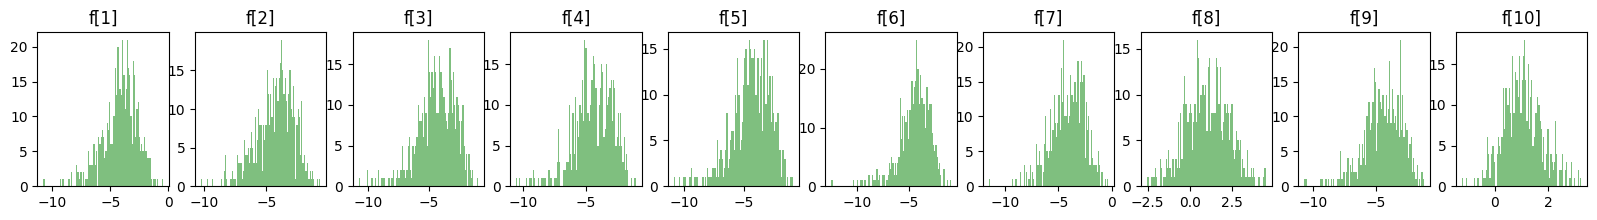

In [247]:
# plot histograms of f[1], f[11], f[21], f[31], f[41], f[51], f[61], f[71], f[81], f[91]
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].hist(samples[f"f[{i+1}]"], bins=100, alpha=0.5, label=f"f[{i+1}]", color='green')
    ax[i].set_title(f"f[{i+1}]")